In [1]:
import sys; sys.path
import pandas as pd
import numpy as np 
import seaborn as sns
import scipy.io as sio
import os
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn import preprocessing, linear_model
from sklearn.metrics import explained_variance_score, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
from joblib import parallel_backend, Parallel, delayed
from prediction_functions4 import shiftedColorMap,prepare_image_data,np_pearson_cor,naive_pearson_cor,feature_select_PCA,feature_select_correlation,scale_data,normalize_data,gcv_ridge,gcv_ridge_strat,parallel_featsearch_strat,parallel_featsearch,gridsearch_cv_strat,gridsearch_cv,plot_figure


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
data_dir = '/home/ubuntu/enigma/'
results_dir='/home/ubuntu/enigma/results/correlation_regionalSDC_shen268/'

df =  pd.read_csv(data_dir + 'Behaviour_Information_ALL_April7_2022.csv', header=0)
idx=np.isnan(df['NORMED_MOTOR'])

df=df[~idx]

site=df['SITE']

chronicity=df['CHRONICITY']
df_chronic=df[df['CHRONICITY']==180]
df_chronic=df_chronic.reset_index(drop=True)
ids=df_chronic['BIDS_ID']
ses=df_chronic['SES']
ids.to_csv(data_dir + '/chronic_ids.csv')

# Load SC regional (chronic)

# sub-r029s005 no MRI?
# sub-r052s034 no MRI?

nROIs=268
sc= np.zeros([len(ids),268])


# unpickle 
import pickle
import numpy as np
import scipy.io as sio
import os
import glob

nROIs=268
sc= np.zeros([len(ids),268])

direct=glob.glob('/home/ubuntu/enigma/268/*chacovol_fs86subj_mean.pkl')
# sub-r029s005 no MRI?
# sub-r052s034 no MRI?

#chacovol
for i in range(0,len(ids)):
    if i==293:
        continue
    if i==519:
        continue
    with open('/home/ubuntu/enigma/shen268/%s_ses-1_space-MNI152_desc-T1-lesion_mask_MNI_1mm_nemo_output_sdstream_chacovol_shen268_mean.pkl' % (ids[i]), 'rb') as e:
        data = pickle.load(e)
        sio.savemat('/home/ubuntu/enigma/shen268/%s_ses-1_space-MNI152_desc-T1-lesion_mask_MNI_1mm_nemo_output_sdstream_chacovol_shen268_mean.mat'% (ids[i]), {'chacovol':data})
        sc[i,:] = data
        
sc = np.delete(sc,(519), axis=0)   
sc = np.delete(sc,(293), axis=0)   

fuglmeyer=df_chronic['NORMED_MOTOR']

fuglmeyer.pop(519)
fuglmeyer.pop(293)



0.477272727

0.3368768225647123
0.2272229777540086


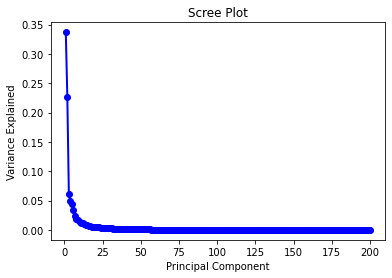

In [4]:
from sklearn.decomposition import PCA
sc.shape
pca = PCA(n_components = 200)

model = pca.fit(sc)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

print(pca.explained_variance_ratio_[0])
print(pca.explained_variance_ratio_[1])

In [7]:
feats

array([  1,   3,   6,   9,  11,  14,  17,  19,  22,  25,  27,  30,  33,
        36,  38,  41,  44,  46,  49,  52,  54,  57,  60,  63,  65,  68,
        71,  73,  76,  79,  81,  84,  87,  90,  92,  95,  98, 100, 103,
       106, 108, 111, 114, 116, 119, 122, 125, 127, 130, 133, 135, 138,
       141, 143, 146, 149, 152, 154, 157, 160, 162, 165, 168, 170, 173,
       176, 179, 181, 184, 187, 189, 192, 195, 197, 200, 203, 205, 208,
       211, 214, 216, 219, 222, 224, 227, 230, 232, 235, 238, 241, 243,
       246, 249, 251, 254, 257, 259, 262, 265, 268])

5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
Best combination: 
 alpha =  0.4520353656360243 
 Features =  65 
 R^2 =  0.163
0.08809466123284626


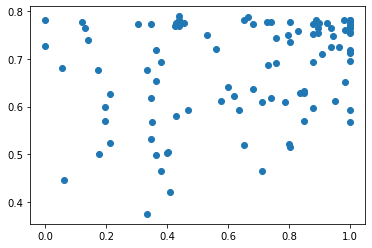

In [6]:
# -------------------- MODEL OPTIMIZATION --------------------
# range of alphas
n_alphas=30
alpha_start=-2
alpha_end=2
alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10,dtype=None)
p=0

#number of features (# pricipal components or variables to retain)
feat_start=1
feat_end=268
n_feats=100
feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

#set the proportion of data you want in your training set
train_size = .8

#set the number of folds you want in the inner and outer folds of the nested cross-validation
k = 5
#set x data to be the input variable you want to use
#ie fc, sc, or hc
#X=np.concatenate([sc, fc], axis=1)
X=np.array(sc)

#set y to be the measure you want to predict
Y = np.array(fuglmeyer)
Y=np.reshape(Y, (627,1))

featselect = 'correlation'

# set aside data for hold-out final testing: 
x, x_test, y, y_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=134)

bestalpha, bestfeats, bestr2, gcv_values_r2= gridsearch_cv(k, x, y, featselect, alphas, feats)

row=np.argmax(np.max(gcv_values_r2, axis=1))
col=np.argmax(np.max(gcv_values_r2, axis=0))
k = 5
bestalpha=alphas[row]
bestfeats=feats[col]

print('Best combination: \n alpha = ', str(alphas[row]), '\n Features = ', str(feats[col]), '\n R^2 = ', str(np.round(np.max(gcv_values_r2), 3)))

# initialize Ridge regression with alpha selected from hyperparameter search
regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_size, shuffle=True, random_state=121)

if featselect=='correlation':
    x_train_featselect,x_test_featureselect,ind = feature_select_correlation(x_train,x_test, y_train, bestfeats)

# initialize Ridge regression with alpha selected from hyperparameter search
regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

# fit model 
y_pred = regr.fit(x_train_featselect, y_train).predict(x_test_featureselect)

expl=explained_variance_score(y_test, y_pred)

print(expl)

plt.scatter(y_test, y_pred)


<ipython-input-29-c606a2cabb90>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


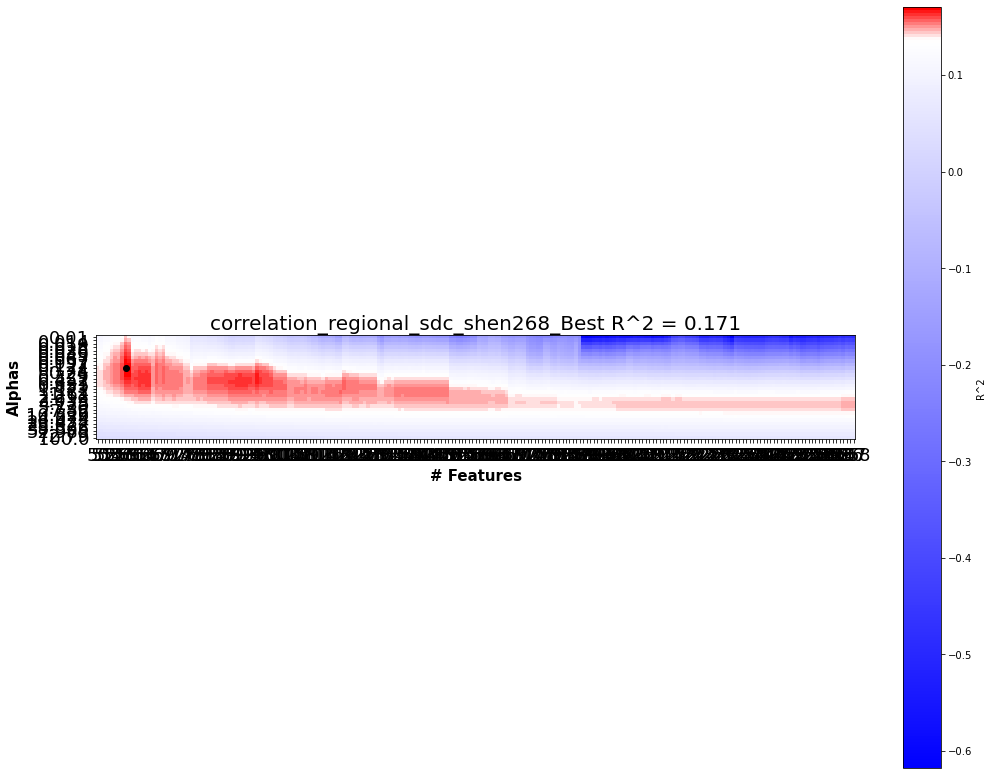

In [32]:
plot_figure(gcv_values_r2,'correlation_regional_sdc_shen268',0.96)

In [29]:
def plot_figure(gcv_values, string, midpoint):
    '''Plots the R^2 value obtained across all grid-search pairs (# features and regularization values.)
    
    Inputs:
        gcv_values - matrix to plot
        string - title
        midpoint - point at which blue turns to red.'''
    
    plt.figure(figsize=(17,14))
    shifted_cmap = shiftedColorMap(plt.get_cmap('bwr'), midpoint=midpoint, name='shifted')

    plt.imshow(gcv_values, cmap=shifted_cmap, interpolation='nearest')

    plt.xlabel('# Features', fontsize=15, fontweight='bold')
    plt.ylabel('Alphas', fontsize=15, fontweight='bold')

    row=np.argmax(np.max(gcv_values, axis=0))
    col=np.argmax(np.max(gcv_values, axis=1))

    ax = plt.axes()

    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(1))

    xticks= np.linspace(feat_start, feat_end,n_feats, dtype=int)
    yticks= np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    plt.xticks(np.arange(len(feats)), fontsize=18)
    plt.yticks(np.arange(len(alphas)), fontsize=18)

    ax.set_xticklabels(xticks)
    ax.set_yticklabels(np.round(yticks,3))

    #ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{xticks: .2f}'))
    cbar = plt.colorbar()
    cbar.set_label('R^2')
    plt.title(string + '_Best R^2 = ' + str(np.round(np.max(gcv_values), 3)), fontsize=20)

    plt.scatter(row,col,color='k')
    #plt.savefig(results_dir+string+ '.png')
    plt.show()

In [31]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    FROM: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [ ]:
# predictions for SC-  PCA and correlation
import datetime
import pickle 

# feature selection type
f=['correlation']

for featselect in f: 
    #set the number of folds you want in the inner and outer folds of the nested cross-validation
    k = 5

    #set the proportion of data you want in your training set
    train_size = .8

    #X=np.concatenate([sc, fc], axis=1)
    X=sc

    #set y to be the measure you want to predict
    #Y = np.log(np.array(tmt))

    Y=np.array(fuglmeyer)
    Y=np.reshape(Y, (627,1))
    
    # range of alphas
    n_alphas=30
    alpha_start=-2
    alpha_end=2
    alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    #number of features (# pricipal components or variables to retain)
    feat_start=1
    feat_end=268
    n_feats=100
    feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)


    # initialize lists to store model results for each permuation
    allR2=[]
    meanR2=[]
    features=[]
    bestalphas=[]
    importance=[]
    allexpl_var=[]
    correlations=[]
    chronic_allexpl_var=[]
    chronic_correlationr2_all=[]
    #joblib-based parallelism to increase speed,
    ytestc=[]
    ypredc=[]
    for p in range(0, 100):
        outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
        print('Permutation: ' + str(p))
        # initialize lists to store model results for eah fold
        R2=[]
        featur=[]
        best_alphas=[]
        impt=[] 
        expl_var=[]
        chronic_explvar=[]
        chronic_correlationr2=[]

        cor=[]
        for train, test in outer_cv.split(X):
            begin_time = datetime.datetime.now()
            
            
            # select model using training data
            bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv(k, X[train], Y[train], featselect, alphas, feats)

            # using optimal num. of features, select final features using entire training data.

            if featselect=='correlation':
                x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)
                featur.append(ind)

            elif featselect=='PCA':
                x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(X[train],X[test], bestfeats)
                featur.append(ind)
                
            # initialize Ridge regression with alpha selected from hyperparameter search
            regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

            # fit model 
            y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

            # store results for each fold k
            impt.append(regr.coef_)
            expl_var.append(explained_variance_score(Y[test], y_pred))
            correlations.append(np_pearson_cor(Y[test], y_pred))
            best_alphas.append(bestalpha)
            print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 
            print("Explained var: " + str(explained_variance_score(Y[test], y_pred)))
            print("correlation: " + str(np_pearson_cor(Y[test], y_pred)))
            
    
            cor.append(np_pearson_cor(Y[test], y_pred))
            Xtest=x_test_featureselect
            Xtrain=X[train]
            Ytest=Y[test]

        # store results for each permutation p

        allexpl_var.append(expl_var)
        bestalphas.append(best_alphas)
        importance.append(impt)
    
        print("---- Permutation avg. explained variance: " + str(np.mean(expl_var)) + "----")
        np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_all_explvar.txt', expl_var, delimiter=',')

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_features.pkl', 'wb')
        pickle.dump(featur, output)
        output.close()
        
        output = open(results_dir + featselect + 'p' + str(p) + '_SC_correlations.pkl', 'wb')
        pickle.dump(correlations, output)
        output.close()

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_bestalphas.pkl', 'wb')
        pickle.dump(best_alphas, output)
        output.close()
     
        output = open(results_dir + featselect + 'p' + str(p) + '_SC_varimpt.pkl', 'wb')
        pickle.dump(impt, output)
        output.close()   
        

Permutation: 0
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:10.967283
Explained var: 0.21150510012437496
correlation: [[0.46269659]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:09.056210
Explained var: 0.25360492989493244
correlation: [[0.51285815]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:09.011697
Explained var: 0.07900910254172955
correlation: [[0.32029707]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:09.042032
Explained var: 0.25265772395475106
correlation: [[0.50694698]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:08.868625
Explaine

time to run loop: 0:00:08.942402
Explained var: 0.19129033631668546
correlation: [[0.43737041]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:09.025250
Explained var: 0.1609671766607057
correlation: [[0.40766899]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:08.969305
Explained var: 0.2760770010780441
correlation: [[0.52998015]]
---- Permutation avg. explained variance: 0.18483409597136552----
Permutation: 8
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:08.846908
Explained var: 0.18804932146612408
correlation: [[0.43476193]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:08.593661
Explained var: 0.22882111214589318
correlation: [[0.4793

time to run loop: 0:00:08.815112
Explained var: 0.21680079342536607
correlation: [[0.46600178]]
---- Permutation avg. explained variance: 0.2083627808542791----
Permutation: 15
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:09.018493
Explained var: 0.3511985119748373
correlation: [[0.60646264]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:08.847188
Explained var: 0.1224649235868196
correlation: [[0.36180902]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:09.022773
Explained var: 0.19139714195669155
correlation: [[0.43804963]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:08.942286
Explained var: 0.17203110931427712
correlation: [[0.4225

time to run loop: 0:00:08.981640
Explained var: 0.14733052758345733
correlation: [[0.41213007]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:08.930141
Explained var: 0.16343346409287285
correlation: [[0.40499399]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:09.066593
Explained var: 0.19755464584539395
correlation: [[0.44821625]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:08.915669
Explained var: 0.18609640021670237
correlation: [[0.43611638]]
---- Permutation avg. explained variance: 0.1852591983902808----
Permutation: 23
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:08.883082
Explained var: 0.18209446522660933
correlation: [[0.43

time to run loop: 0:00:09.013621
Explained var: 0.17804319653685774
correlation: [[0.42270772]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:09.013902
Explained var: 0.09559921992790332
correlation: [[0.414407]]
---- Permutation avg. explained variance: 0.17459478567670897----
Permutation: 30
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:08.787879
Explained var: 0.20209801307993214
correlation: [[0.45199431]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:08.966198
Explained var: 0.1893451068345493
correlation: [[0.43811033]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:08.954906
Explained var: 0.18092579402363151
correlation: [[0.4290

In [3]:
# Haufe transformation of feature weights
k=5
Y = np.array(fuglmeyer)

perm=0
fullactivations=[] 
#iterate through permutations
for p in range(0,100):
    k=5
    
    # load activation weights
    with open(results_dir + 'correlation' + 'p' + str(p) + '_SC_varimpt.pkl', 'rb') as f:
        activ = pickle.load(f)
        
    outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
    
    # Load features selected from permutation
    with open(results_dir + 'correlation' + 'p' + str(p) + '_SC_features.pkl', 'rb') as f:
        feats = pickle.load(f)
    
    c=0   
    activations=[]
    X=sc

    fullactivation=[]
    activationweight=[]
    for train, test in outer_cv.split(X):
        x_train=X[train]
        X=x_train
        X_sub=X[:,feats[c][:]]
        
        X_sub=np.reshape(X_sub, [len(train),feats[c].shape[0]])
        cov_x=np.cov(np.transpose(X_sub))
        
        print(X_sub.shape)
        if feats[c].shape[0]==1:
            cov_x=np.reshape(cov_x, [1,1])
        
    
        cov_y=np.cov(np.transpose(Y[train]))
    
        activationweight=activ[c]

        #print(activationweight.shape)
        weight=np.transpose(activationweight)

        print(cov_x.shape)
        print(weight.shape)
        print(cov_y.shape)
        activation=np.matmul(cov_x,weight)*(1/cov_y)
        activations.append(activation)
        #print(activation.shape)

        # get activation weights back to matrix form 86x86
        # get indices of weights not selected as features; set weight to 0    
        idx=np.ones(shape=(268,1), dtype='bool')
        idx[feats[c]]=False # set SC weights that are features to be 1
        idx=idx.flatten()
        zeroidx=np.arange(0, 268, dtype='int')
        zeroidx=zeroidx[idx]
        
        # fill spots with 0's (up to 3192)
        k=0
        activation_full = activation
        while k < zeroidx.shape[0]:
            activation_full=np.insert(activation_full, zeroidx[k],0)
            k=k+1
        
        #print("Full 3192: " + str(np.sum(activation_full>0)))
        # fill spots with 0's (up to 3655)
        X=sc
        zeros=sc==0
        zeros=np.sum(zeros,0) # number of zeros across subjects
        zeros=zeros==X.shape[0] # find columns with zeros for all 101 subjects
        X=X[:,~zeros]
        
        zeroidx=np.arange(0, 268)
        zeroidx=zeroidx[zeros]

        # fill spots with 0's
        k=0
        a = activation_full
        while k < zeroidx.shape[0]:
            a=np.insert(a, zeroidx[k],0)
            k=k+1
        
        #print("Full 268: " + str(np.sum(a>0)))
        fullactivation.append(a)
        c=c+1
         
    fullactivations.append(fullactivation)

(501, 121)
(121, 121)
(121, 1)
()
(501, 117)
(117, 117)
(117, 1)
()
(502, 101)
(101, 101)
(101, 1)
()
(502, 75)
(75, 75)
(75, 1)
()
(502, 86)
(86, 86)
(86, 1)
()
(501, 122)
(122, 122)
(122, 1)
()
(501, 117)
(117, 117)
(117, 1)
()
(502, 86)
(86, 86)
(86, 1)
()
(502, 171)
(171, 171)
(171, 1)
()
(502, 233)
(233, 233)
(233, 1)
()
(501, 144)
(144, 144)
(144, 1)
()
(501, 156)
(156, 156)
(156, 1)
()
(502, 115)
(115, 115)
(115, 1)
()
(502, 161)
(161, 161)
(161, 1)
()
(502, 94)
(94, 94)
(94, 1)
()
(501, 80)
(80, 80)
(80, 1)
()
(501, 84)
(84, 84)
(84, 1)
()
(502, 88)
(88, 88)
(88, 1)
()
(502, 88)
(88, 88)
(88, 1)
()
(502, 141)
(141, 141)
(141, 1)
()
(501, 93)
(93, 93)
(93, 1)
()
(501, 265)
(265, 265)
(265, 1)
()
(502, 108)
(108, 108)
(108, 1)
()
(502, 74)
(74, 74)
(74, 1)
()
(502, 152)
(152, 152)
(152, 1)
()
(501, 123)
(123, 123)
(123, 1)
()
(501, 81)
(81, 81)
(81, 1)
()
(502, 78)
(78, 78)
(78, 1)
()
(502, 145)
(145, 145)
(145, 1)
()
(502, 97)
(97, 97)
(97, 1)
()
(501, 132)
(132, 132)
(132, 1)
(

(501, 103)
(103, 103)
(103, 1)
()
(501, 110)
(110, 110)
(110, 1)
()
(502, 128)
(128, 128)
(128, 1)
()
(502, 103)
(103, 103)
(103, 1)
()
(502, 167)
(167, 167)
(167, 1)
()
(501, 93)
(93, 93)
(93, 1)
()
(501, 82)
(82, 82)
(82, 1)
()
(502, 97)
(97, 97)
(97, 1)
()
(502, 126)
(126, 126)
(126, 1)
()
(502, 164)
(164, 164)
(164, 1)
()
(501, 85)
(85, 85)
(85, 1)
()
(501, 75)
(75, 75)
(75, 1)
()
(502, 75)
(75, 75)
(75, 1)
()
(502, 116)
(116, 116)
(116, 1)
()
(502, 81)
(81, 81)
(81, 1)
()
(501, 84)
(84, 84)
(84, 1)
()
(501, 129)
(129, 129)
(129, 1)
()
(502, 90)
(90, 90)
(90, 1)
()
(502, 140)
(140, 140)
(140, 1)
()
(502, 129)
(129, 129)
(129, 1)
()
(501, 144)
(144, 144)
(144, 1)
()
(501, 94)
(94, 94)
(94, 1)
()
(502, 138)
(138, 138)
(138, 1)
()
(502, 166)
(166, 166)
(166, 1)
()
(502, 148)
(148, 148)
(148, 1)
()
(501, 137)
(137, 137)
(137, 1)
()
(501, 77)
(77, 77)
(77, 1)
()
(502, 104)
(104, 104)
(104, 1)
()
(502, 86)
(86, 86)
(86, 1)
()
(502, 72)
(72, 72)
(72, 1)
()
(501, 153)
(153, 153)
(153, 1)
(

In [5]:
# SC average across stroke subjects
from nilearn import datasets
from nilearn import plotting

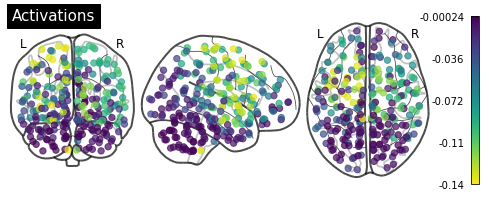

In [6]:
shen268_activations=np.empty((268,)) 

for p in range(0,100):
    act=fullactivations[p] # features 
    for x in range(0,5):
        shen268_activations=np.vstack((shen268_activations, np.transpose(act[x])))
        
shen268_region=np.mean(shen268_activations[1:],axis=0)

coordinates = plotting.find_parcellation_cut_coords('/home/ubuntu/enigma/shen_2mm_268_parcellation.nii')
plotting.plot_markers(shen268_region, coordinates,node_size=40,
                         title='Activations',colorbar=True)

np.savetxt(results_dir + 'avgHaufe_shen268_regionalSDC_correlation_chronic.txt', shen268_region, delimiter=',')
np.savetxt(results_dir + 'allHaufe_shen268_regionalSDC_correlation_chronic.txt', shen268_activations[1:], delimiter=',')


In [171]:
shen268_activations

array([[ 6.92989860e-310,  6.92989860e-310,  4.68297925e-310, ...,
        -5.68749510e-002, -6.32723847e-002,  0.00000000e+000],
       [ 0.00000000e+000, -1.41107865e-002,  0.00000000e+000, ...,
        -5.68749510e-002, -6.32723847e-002,  0.00000000e+000],
       [ 0.00000000e+000, -2.07707475e-002,  0.00000000e+000, ...,
        -7.83878577e-002,  0.00000000e+000,  0.00000000e+000],
       ...,
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
        -1.32597880e-001,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000, -3.75734457e-002,  0.00000000e+000, ...,
        -1.75240258e-001,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
        -1.34711878e-001,  0.00000000e+000,  0.00000000e+000]])